# Identify Coupled Patterns between SLP and SST through Maximum Covariance Analysis

Maximum Correlation Analysis (MCA; Bretherton et al., 1992) is similar to Empirical Orthogonal Function Analysis (EOF) in that they both deal with the decomposition of a covariance matrix. In EOF, this is a covariance matrix based on a single spatio-temporal field, while MCA is based on the decomposition of a "cross-covariance" matrix derived from two variables. The resulting expansion coefficients (ECs) associated with the left and right singular vectors can then be projected onto the original data to obtain homogeneous and heterogeneous regression maps. 

This notebook applies MCA method to real data—the tropical Pacific sea level pressure (SLP) and sea surface temperature (SST) fields—and identify the coupled patterns from the data, including the famous tropical Pacific climate variability known as the El Nin o–Southern Oscillation (ENSO). ENSO has warm El Nino states and cool La Nina states, with changes found not only in the SST but also in the SLP.

The MCA approach is chosen because it is able to capture patterns of maximum covariance between two variables; it has been found to reasonably capture atmospheric and oceanic processes (Wilks, 2015). It is a robust
method to investigate dominant modes of interaction, because it favors a better understanding of the relationship between groups of variables (Frankignoul et al., 2011). 

The SLP and SST data are downloaded from http://www.esrl.noaa.gov/psd/gcos_wgsp/Gridded/data.hadslp2.html and http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/kaplan_sst/catalog.html, respectively.

## 1. Load all needed libraries

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

mpl.rcParams['figure.figsize'] = 8.0, 4.0 
mpl.rcParams['font.size'] = 13  

## 2. Load data

Spatial domain: -180W ~ -70W, and 30N ~ -30S

Period: 1950~2005

Raw SLP and SST are converted to monthly anomalies

### 2.1 SLP

In [2]:
ds1 = xr.open_dataset('data/slp.mnmean.hadslp2.nc')
slp = ds1.slp.sel(lat=slice(30, -30), lon=slice(180, 290), time=slice('1950-01-01','2005-12-31'))
lon_slp = ds1.lon.sel(lon=slice(180, 290))
lat_slp = ds1.lat.sel(lat=slice(30, -30))
dates = ds1.time.sel(time=slice('1950-01-01','2005-12-31')).values
# climatology
slp_clm = slp.groupby('time.month').mean(dim='time')
# anomaly
slp_anom = slp.groupby('time.month') - slp_clm

### 2.2 SST

In [3]:
ds2 = xr.open_dataset('data/sst.mon.anom.kaplan.nc')
sst_anom = ds2.sst.sel(lat=slice(-30, 30), lon=slice(180, 290), time=slice('1950-01-01','2005-12-31'))
lat_sst = ds2.lat.sel(lat=slice(-30, 30))
lon_sst = ds2.lon.sel(lon=slice(180, 290))

### 2.3 Preprocess

Convert 3D SLP and SST to 2D arrays and only use none-NaN values of SST.

In [4]:
slp2d = slp_anom.values
ntime, nrow_slp, ncol_slp = slp2d.shape
slp2d = np.reshape(slp2d, (ntime, nrow_slp*ncol_slp), order='F')

sst2d = sst_anom.values
ntime, nrow_sst, ncol_sst = sst2d.shape
sst2d = np.reshape(sst2d, (ntime, nrow_sst*ncol_sst), order='F')

nonMissingIndex = np.where(np.isnan(sst2d[0]) == False)[0]
sst2dNoMissing = sst2d[:, nonMissingIndex]

## 3. Carry out Maximum Covariance Analysis

The key step is to apply SVD to decompose the covariance matrix of SLP and SST. It is worth noting that np.linalg.svd will produce V.T, instead of V. In practice, have to transpose it.

### 3.1 MCA

In [5]:
Cxy = np.dot(slp2d.T, sst2dNoMissing)/(ntime-1.0)
U, s, V = np.linalg.svd(Cxy, full_matrices=False)
V = V.T

### 3.2 Postprocess
* Calculate cumulative fraction of squares covariance explained
* Extract the leading SLP MCA pattern and EC
* Extract the leading SST MCA pattern and EC

Normalize MCD mode 1 by standardizing the EC1, so patterns correspond to a 1-std deviation variation in EC1. The positive EC1 of SST should match the Nino SSTA.

#### 3.2.1 Calculate cumulative fraction of squares covariance explained

In [6]:
scf = s**2./np.sum(s**2.0)

#### 3.2.2 Extract the leading SLP MCA pattern and EC

In [7]:
# SLP MCA pattern
U1 = np.reshape(U[:,0, None], (nrow_slp, ncol_slp), order='F')
# EC1 of SLP
a1 = np.dot(slp2d, U[:,0, np.newaxis])
# normalize
U1_norm = U1*np.std(a1)
a1_norm = a1/np.std(a1)

#### 3.2.3 Extract the leading SST MCA pattern and EC

In [8]:
# SST MCA pattern
V1 = np.ones([nrow_sst*ncol_sst,1]) * np.NaN
V1 = V1.astype(V.dtype)
V1[nonMissingIndex,0] = V[:,0]
V1 = V1.reshape([nrow_sst,ncol_sst], order='F')

# EC1 of SST
b1 = np.dot(sst2dNoMissing, V[:,0, np.newaxis])

# normalize
V1_norm = V1*np.std(b1)
b1_norm = b1/np.std(b1)

## 4 Visualize MCA results
### 4.1 Plot cumulative fraction of squares covariance explained

(-0.5, 40)

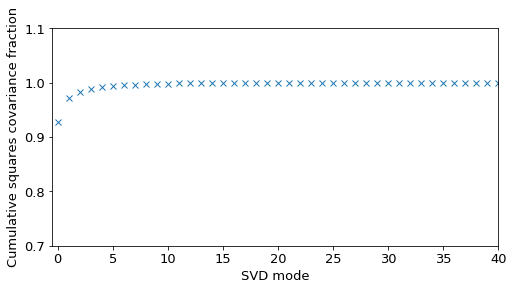

In [9]:
plt.plot(np.cumsum(scf),'x') 
plt.xlabel('SVD mode')
plt.ylabel('Cumulative squares covariance fraction')
plt.ylim([0.7,1.1])
plt.xlim([-0.5, 40])

### 4.2 Plot the leading SLP/SST MCA spatial pattern and EC

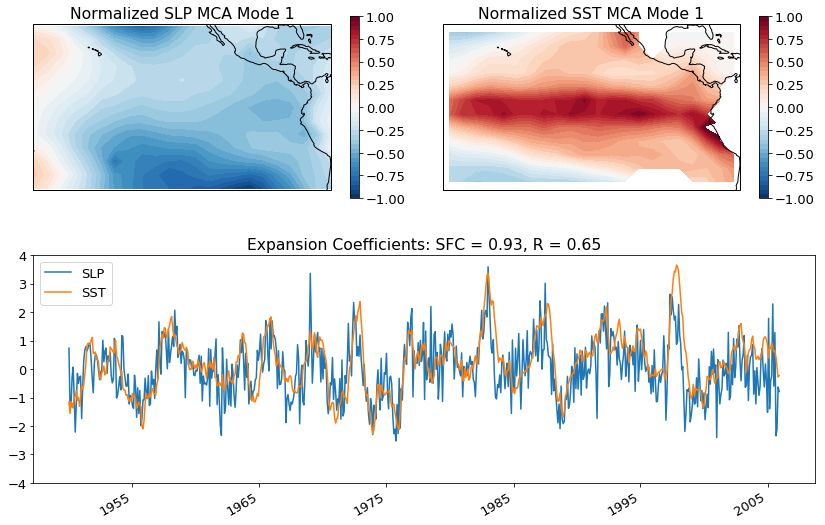

In [10]:
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)
fig = plt.figure(figsize = (14,10))
levels = np.arange(-1.0, 1.01, 0.05)

# SLP Pattern
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_slp, lat_slp)
cs = ax0.contourf(x1, y1, U1_norm,
                        levels=levels,
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu_r')
    
cb=fig.colorbar(cs, ax=ax0, shrink=0.8, aspect=20)    
ax0.coastlines()
ax0.set_global()
ax0.set_extent([-180, -70, -19, 19])
ax0.set_title('Normalized SLP MCA Mode 1')
  
    
# SST Pattern
ax1 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
x2, y2 = np.meshgrid(lon_sst, lat_sst)
cs2 = ax1.contourf(x2, y2, V1_norm,
                        levels=levels, 
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu_r')
    
cb=fig.colorbar(cs, ax=ax1, shrink=0.8, aspect=20)    
ax1.coastlines()
ax1.set_global()
ax1.set_extent([-180, -70, -19, 19])
ax1.set_title('Normalized SST MCA Mode 1')


# EC1
ax2 = fig.add_subplot(gs[1,:]) 
ax2.plot(dates, a1_norm, label='SLP')
ax2.plot(dates, b1_norm, label='SST')
r = np.corrcoef(a1[:,0], b1[:,0])[0, 1]
ax2.set_title('Expansion Coefficients: SFC = '+ str(round(scf[0],2)) + ', R = ' + str(round(r,2)))
ax2.legend()
ax2.set_ylim([-4,4])

ax2.format_xdata = mdates.DateFormatter('%Y')
fig.autofmt_xdate()

## 5. Summary

The above figure shows the first MCA mode calculated between the monthly anomaly fields of Sea Surface Pressure (SLP) and Sea Surface Temperature (SST) for the region of the equatorial Pacific. Mode 1 explains a large portion of the squared covariance (93%) and shows the strong large scale coupling between SLP and SST anomalies (e.g. areas with positive MCA values in SLP appear to coincide with negative SST). This is what we would expect of the El Niño Southern Oscillation (ENSO) - High SLP anomalies in the western Pacific is typical of the warm El Niño phase, which results in warmer SST anomalies throughout the equatorial Pacific. The opposite La Niña phase results from low SLP in the western Pacific.


## References

Allan, R., and T. Ansell, 2006: A New Globally Complete Monthly Historical Gridded Mean Sea Level Pressure Dataset (HadSLP2): 1850-2004. J. Climate, 19, 5816-5842.

Kaplan, A., M. Cane, Y. Kushnir, A. Clement, M. Blumenthal, and B. Rajagopalan, Analyses of global sea surface temperature 1856-1991, Journal of Geophysical Research, 103, 18,567-18,589, 1998

Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011)

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Hoyer, S. & Hamman, J., (2017). xarray: N-D labeled Arrays and Datasets in Python. Journal of Open Research Software. 5(1), p.10. DOI: http://doi.org/10.5334/jors.148

Bretherton CS, Smith C, Wallace JM (1992) An intercomparison of methods for finding coupled patterns in climate data. J Clim 5:541–560

Frankignoul C, Chouaib N, Liu Z (2011) Estimating the observed atmospheric response to SST anomalies: maximum covariance analysis, generalized equilibrium feedback assessment, and maximum response estimation. J Climate 24(10):2523–2539. doi:10.1175/2010JCLI3696.1

Wilks DS (2015) Multivariate ensemble model output statistics using empirical copulas. Q J R Meteorol Soc 141(688):945–952